# Installations required (Commented out)

In [1]:
#!/usr/local/opt/python/bin/python2.7 -m pip install matplotlib==2.0.2

In [2]:
#!/usr/local/opt/python/bin/python2.7 -m pip install scipy

In [3]:
#!/usr/local/opt/python/bin/python2.7 -m pip install scikit-learn

In [4]:
#!/usr/local/opt/python/bin/python2.7 -m pip install scikit-image

In [5]:
#!pip3 install scikit-image

In [6]:
#!/usr/local/opt/python/bin/python2.7 -m pip install Pillow

In [7]:
#!pip2 install tqdm

In [8]:
#!pip3 install scikit-learn

In [9]:
#!pip3 install scipy

In [10]:
#import sys
#print(sys.executable)

In [11]:
#!brew install openslide
#!/usr/local/opt/python/bin/python2.7 -m pip install openslide-python

# Project -1 : Find percentage of a cancer in a whole slide image

## Configuration file [Run this]

In [12]:
import os

# directory of the config file
CURRENT_DIR = os.path.realpath('.')

DEFAULT_FILENAME = 'slide'

IMAGE_FOLDER_PATH = CURRENT_DIR+"/input"

OUTPUT_FOLDER_PATH = CURRENT_DIR+"/output"

IMG_FORMAT = 'jpeg'

TILE_SIZE = 2000

OVERLAP = 0

LIMIT_BOUNDS = True

QUALITY = 100

NUM_WORKERS = 12

ONLY_LAST = True

SAVE_REJECTED = False

DONT_REJECT = True

# increase this to reject more
REJECT_THRESHOLD = 200

ROTATE = False

MAX_WHITE_SIZE = (TILE_SIZE*TILE_SIZE)/2

def ver_print(string, value):
    print(string + " {0}".format(value))

## Preprocessing and tilling [Run this]

In [13]:
import glob
import os
from tqdm import tqdm
import PIL
import cv2
from PIL import Image
from tiler import WholeSlideTiler

def main():
    files = glob.glob(IMAGE_FOLDER_PATH + '/*.svs')
    for slidepath in tqdm(files):
        basename = os.path.splitext(os.path.basename(slidepath))[0]
        basepath = os.path.join(OUTPUT_FOLDER_PATH, basename)
        WholeSlideTiler(slidepath, basepath, IMG_FORMAT, TILE_SIZE, OVERLAP, LIMIT_BOUNDS, ROTATE,
                        QUALITY, NUM_WORKERS, ONLY_LAST).run()


if __name__ == '__main__':
    main()


Tiling slide: wrote 1449/1449 tiless]


Tiling completed on slide in:  <time here>
Tiling completed on label in:  <time here>


Tiling label: wrote 1/1 tiles
Tiling macro: wrote 1/1 tiles
Tiling thumbnail: wrote 1/1 tiles


Tiling completed on macro in:  <time here>
Tiling completed on thumbnail in:  <time here>


100%|██████████| 1/1 [05:13<00:00, 313.41s/it]


## Method: Normalizing [Run This]

In [14]:
from __future__ import division

import glob

import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image 
from numpy import random
import os


def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))


def normalize_staining(I=None):
    I = I.astype(np.float64)
    Io = 240
    beta = 0.15
    alpha = 1
    HERef = np.array([[0.5626, 0.2159], [0.7201, 0.8012], [0.4062, 0.5581]])
    maxCRef = np.array([1.9705, 1.0308])

    (h, w, c) = np.shape(I)
    I = np.reshape(I, (h * w, c), order='F')

    # Step 1. Convert RGB to OD.
    OD = - np.log((I + 1) / Io) # optical density where each channel in the image is normalized to values between [0, 1]

    # Step 2. Remove data with OD intensity less than beta
    ODhat = (OD[(np.logical_not((OD < beta).any(axis=1))), :])

    # Step 3. Calculate SVD on the OD tuples
    cov = np.cov(ODhat, rowvar=False)
    (W, V) = np.linalg.eig(cov)

    # Step 4. create plane from the SVD directions
    # corresponding to the two largest singular values
    Vec = - np.transpose(np.array([V[:, 1], V[:, 0]]))

    # Step 5. Project data onto the plane and normalize to unit Length
    That = np.dot(ODhat, Vec)

    # Step 6. Calculate angle of each point w.r.t the first SVD direction
    phi = np.arctan2(That[:, 1], That[:, 0])

    # Step 7. Find robust extremes (some alpha th and (100 - alpha th) percentiles of the angle
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)
    vMin = np.dot(Vec, np.array([np.cos(minPhi), np.sin(minPhi)]))
    vMax = np.dot(Vec, np.array([np.cos(maxPhi), np.sin(maxPhi)]))
    if vMin[0] > vMax[0]:
        HE = np.array([vMin, vMax])
    else:
        HE = np.array([vMax, vMin])

    HE = np.transpose(HE)

    # Step 8. Convert extreme values back to OD space
    Y = np.transpose(np.reshape(OD, (h * w, c)))
    C = np.linalg.lstsq(HE, Y,rcond=None)
    maxC = np.percentile(C[0], 99, axis=1)
    C = C[0] / maxC[:, None]
    C = C * maxCRef[:, None]
    Inorm = Io * np.exp(- np.dot(HERef, C))
    Inorm = np.reshape(np.transpose(Inorm), (h, w, c), order='F')
    Inorm = np.clip(Inorm, 0, 255)
    Inorm = np.array(Inorm, dtype=np.uint8)

    return Inorm  # ,H,E


## Normalizing All Tiles [Run This]

In [15]:
def main():

    list_img = glob.glob(glob.glob("output/*/")[0]+"slide/*/*.jpeg")
    for filename in list_img: #WILL TAKE VERY LONG
        fileout = os.path.splitext(filename)[0]+"_normal.jpeg"
        img = cv2.imread(filename)
        img = img.astype(np.float64)

        img = normalize_staining(img)

        cv2.imwrite(fileout, img)
        # Uncomment for tile display
        #img_show = Image.open(fileout)
        #img_show.show()  
        
main()


### METHOD: Possible Clustering evaluation (Feasible to run only on re-sized image, as entire image causes kernel to crash) [Run this IF silhoutte analysis needs to be performed]

In [16]:
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

###########Helper Functions##################
def sil_best_clusters(image_to_clust):
 bestSilhouette = -1
 bestClusters = 0;
 range_of_k = 3

 for clusters in range(2, range_of_k):
	 # Cluster colours
	 clt = KMeans(n_clusters = clusters)
	 clt.fit(image_to_clust)

	 # Validate clustering result
	 silhouette = metrics.silhouette_score(image_to_clust, clt.labels_, metric='euclidean')

	 # Find the best one
	 if silhouette > bestSilhouette:
		 bestSilhouette = silhouette;
		 bestClusters = clusters;
        
 return(bestClusters)
############################################

#print("Ideal number of clusters: " + str(sil_best_clusters(imageresized_array))) #Running only with resized image

### METHOD: Clustering dominant colours with K-Means, and annotating all pixels with color centroids [Run This]
#### K-Means clustering finds 3 color clusters of pixels, summing the RGB value and ranking cluster centroids gives us white, pink and purple clusters (high sum(RGB) = white, low sum(RGB) = purple and middle sum(RGB) = pink

In [17]:
# Some code used from Adrian Rosebrock's k-means to find dominant colors tutorial
from sklearn.cluster import KMeans
from collections import Counter
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
import scipy.spatial.distance
from scipy.spatial import distance
import numpy as np
from scipy.stats import rankdata
import cv2
import matplotlib.pyplot as plt
from __future__ import division

###########Helper Functions##################
def centroid_histogram(clt):
     # grab the number of different clusters and create a histogram
     # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

     # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

     # return the histogram
    return hist

def plot_colors(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	bar = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0

	# loop over the percentage of each cluster and the color of
	# each cluster
	for (percent, color) in zip(hist, centroids):
		# plot the relative percentage of each cluster
		endX = startX + (percent * 300)
		cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
			color.astype("uint8").tolist(), -1)
		startX = endX
	
	# return the bar chart
	return bar


#pink = [255,192,203]
#purple = [128,0,128]
#white = [255,255,255]


def get_pixel_color_counts(img_arr,showdetails): 
    # Clusters the pixels
    clt = KMeans(n_clusters = 3)
    clt.fit(img_arr)
    # Find cluster labels for each pixel
    labels = clt.predict(img_arr)
    # How many pixels in each cluster
    Num_pix = Counter(labels)

    # Debugging print statements
    #print(Counter(labels))
    #print(clt.cluster_centers_)

    # Get the sum of R,G,B values for cluster centroids
    myList = [sum(item) for item in np.array(clt.cluster_centers_)]

    # Rank the sum of R,G,B values for cluster centroids (Higher the value, more proclivity for white, lower value will be dark purple, middle value will be pink/red)
    ranks =((rankdata(myList) - 1).astype(int))

    if showdetails:    
    # Print cluster and member cluster details
        print("White is cluster: "+ str(np.where(np.isin(ranks,[2]))[0][0]+1)+", With # pixels = "+ str(Num_pix[np.where(np.isin(ranks,[2]))[0][0]]))
        print("Pink/red is cluster: "+ str(np.where(np.isin(ranks,[1]))[0][0]+1)+", With # pixels = "+ str(Num_pix[np.where(np.isin(ranks,[1]))[0][0]]))
        print("Purple is cluster: "+ str(np.where(np.isin(ranks,[0]))[0][0]+1)+", With # pixels = "+ str(Num_pix[np.where(np.isin(ranks,[0]))[0][0]]))

    #Show cluster colors and bar histogram
        hist = centroid_histogram(clt)
        bar = plot_colors(hist, clt.cluster_centers_)
        zipped = zip (hist, clt.cluster_centers_)
        hist, clt.cluster_centers = zip(*zipped)
        i=0
        for rgb in (clt.cluster_centers_).round():
            plt.title(i+1)
            plt.imshow([[(rgb/255)]])
            plt.show()
            i+=1

            plt.imshow(bar)
            plt.show()
    
    total_pixels = len(labels)
    return([total_pixels,Num_pix[np.where(np.isin(ranks,[2]))[0][0]]/total_pixels,Num_pix[np.where(np.isin(ranks,[1]))[0][0]]/total_pixels,Num_pix[np.where(np.isin(ranks,[0]))[0][0]]/total_pixels])
#############################################
#white,pink,purple = get_pixel_color_counts(imageorig_array,False)

## Loading, resizing and processing tiles to annotate pixels with color [Run This]
### "Purpleness" is decided by unsupervised k-means clustering to find dominant colors
#### All pixels in the "purple" cluster are considered "purple or cancerous"

In [18]:
# Load the image
from skimage import io, color
import cv2
import numpy as np
import os

white_all_tiles = []
pink_all_tiles = []
white_all_tiles = []
purple_all_tiles = []
total_all_tiles = []

list_img = glob.glob(glob.glob("output/*/")[0]+"slide/*/*_normal.jpeg")

for filename in list_img: #WILL TAKE VERY LONG
       
    imageorig = cv2.imread(filename)
    print("Working on "+ os.path.basename(filename))
    # Resize it
    h, w, _ = imageorig.shape
    w_new = int(100 * w / max(w, h) )
    h_new = int(100 * h / max(w, h) )
    image = cv2.resize(imageorig, (w_new, h_new));
    # Using original image (possible to use resized image above for faster processing)
    # Reshape image to be a list of pixels
    imageorig_array = imageorig.reshape((imageorig.shape[0] * imageorig.shape[1], 3))
    total,white,pink,purple = get_pixel_color_counts(imageorig_array,False)
    total_all_tiles.extend([total])
    white_all_tiles.extend([white])
    pink_all_tiles.extend([pink])
    purple_all_tiles.extend([purple])




    
    
    
    
#convert color space from RGB to LAB
#image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)


# This line is to set L values to 0 and keep A and B
#image[:,:,0]= 0
#print(image)

#cv2.imshow('image',image)
#cv2.waitKey(0)
#print(image[0][0])


Working on 10_9_1_normal.jpeg
Working on 11_8_1_normal.jpeg
Working on 11_9_1_normal.jpeg
Working on 13_18_1_normal.jpeg
Working on 14_6_1_normal.jpeg
Working on 34_15_1_normal.jpeg
Working on 35_9_1_normal.jpeg
Working on 38_7_1_normal.jpeg
Working on 39_6_1_normal.jpeg
Working on 40_4_1_normal.jpeg
Working on 57_8_1_normal.jpeg
Working on 57_9_1_normal.jpeg
Working on 60_5_1_normal.jpeg
Working on 61_6_1_normal.jpeg
Working on 61_7_1_normal.jpeg
Working on 62_7_1_normal.jpeg
Working on 9_10_1_normal.jpeg


## Plot histograms of ratio of white, pink and purple pixels over total number of pixels across tiles [Run This]

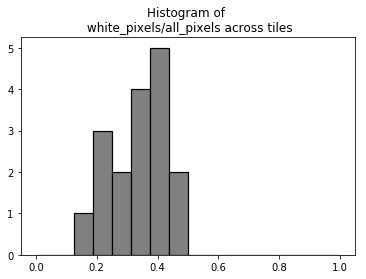

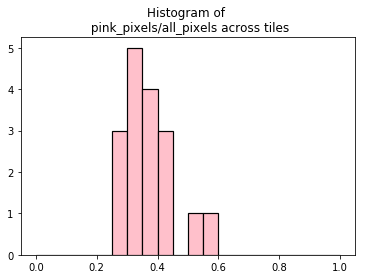

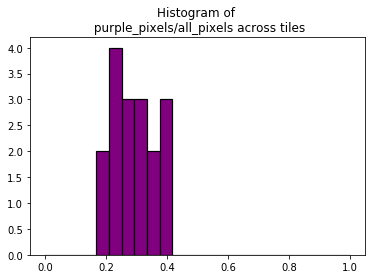

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(white_all_tiles, bins='auto',color = "gray",edgecolor='black', linewidth=1.2,range=[0, 1])  # arguments are passed to np.histogram
plt.title("Histogram of \n white_pixels/all_pixels across tiles")
plt.show()
plt.hist(pink_all_tiles, bins='auto',color = "pink",edgecolor='black', linewidth=1.2,range=[0, 1])  # arguments are passed to np.histogram
plt.title("Histogram of \n pink_pixels/all_pixels across tiles")
plt.show()
plt.hist(purple_all_tiles, bins='auto',color = "purple",edgecolor='black', linewidth=1.2,range=[0, 1])  # arguments are passed to np.histogram
plt.title("Histogram of \n purple_pixels/all_pixels across tiles")
plt.show()

## Find sum of purple/non-purple over all tiles and estimate total cancer [Run This]

In [20]:
#Total pixels across all tiles
total_pixels_of_tiles = sum(total_all_tiles)
#Total purple pixels across all tiles (((ratio of purple/all pixels) * all pixels) in each tile)
total_purple_pixels_of_tiles = sum([a*b for a,b in zip(purple_all_tiles,total_all_tiles)])
#Total cancer is total purple pixels/total all pixels
print("Total cancer: "+ str(total_purple_pixels_of_tiles/total_pixels_of_tiles*100)+'%')

Total cancer: 29.490623529411764%


## Test of various ways to annotate pink, white and purple pixels (Commented out)

In [21]:
#from scipy.spatial import distance
#import numpy as np
#from scipy.stats import rankdata

#pink = [255,192,203]
#purple = [128,0,128]
#white = [255,255,255]

#a = np.array([pink,white,purple])
#b = np.array([[232.21804653,225.47207084,235.11397529],[67.25475005,28.18760198,62.60561427],[136.8342103,93.84363329,161.96761943]])
#d = distance.cdist(a, b, 'euclidean')
#print(d[:,2])
#values = d[:,2]

#myList = [sum(item) for item in b]
#print((rankdata(myList) - 1).astype(int))
#myList = [501,2,500,3]
#print(np.argsort(myList))
#print([c[0] for c in sorted(enumerate(myList),key=lambda i:i[1])])
#print(np.sum(b[0]))
#print(np.sum(b[1]))
#print(np.sum(b[2]))
#print(np.argmin(values))
#print(distance.euclidean(a[1],b[0]))

## Possible way of counting colors per pixel (if exact color range is known) (Commented out)

In [22]:
#from PIL import Image , ImageStat


#im = Image.open("112_16_1.jpeg").convert('L')
#stat = ImageStat.Stat(im)
#print("Read RMS brightness of image: ")
#print(stat.extrema)
#print(stat.count)
#print(stat.sum)


#black = 0
#red = 0

#for pixel in im.getdata():
    #if pixel == (0, 0, 0): # if your image is RGB (if RGBA, (0, 0, 0, 255) or so
       # black += 1
    #else:
     #   red += 1
#print('black=' + str(black)+', red='+str(red))

# Outcomes and Findings:

There was distinct change is cancer percentage when changing tile size.

For tile size = 1000: Cancer ~26%

For tile size = 2000: Cancer ~29%
